###### Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP1_NAME1_NAME2` (or `SL_TP1_NAME` if you work alone).

**Deadline: Friday, December 5, 11:59 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2025/StoreManagement.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
  # install rlberry library
  !pip install scipy rlberry

## Store Management MDP

You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [2]:
import numpy as np
import random as rd
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

### Problem parameters 

In [4]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

As an example of demand distribution, we choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. We provide below a function that simulate the demand. 

In [5]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  1


### Encoding the MDP as a gymnasium environment

This is just a  toy example on how to create a gymnasium environement. 

Note that our environement is an example of tabular MDP for which the transition probabilities $P(s'|s,a)$ and the mean rewards $r(s,a)$ can actually be computed in closed form. Therefore we provide the transitions $(P)$ and mean rewards $(r)$ as attributes of the class. 

In [6]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        pdem = np.array([q*(1-q)**m for m in range(M+1)])
        pdem[M] = pdem[M]+1-np.sum(pdem)
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

        # computation of the MDP parameters
        P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
        r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a
        ## iteration over all possible states, actions, and possible demand values
        for a in range(M+1):
            for s in range(M+1):
                for d in range(M+1):
                    # next state and reward with demand d
                    ns = max(0,min(M,s+a) -d)
                    reward = -c*a - h*s+p*min(M,d,s+a)
                    if (a>0):
                        reward = reward - c0
                    P[s,a,ns] += pdem[d]
                    r[s,a] += pdem[d] * reward
        self.P = P # P[s,a,ns] = P(ns | s,a)
        self.r = r # r[s,a] = r(s,a)

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 4 elements: observation / reward / termination? / truncation ? / information  
        return self.state, reward, False, False,{}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

**Complete the function below to simulate a trajectory of length $T$ from an initial state $s_0$ under a policy Pi**

Write a function `SimulateTrajectory` that takes 3 arguments T, Pi and s0. It should initialize a StoreManagement environment in the state s0. Then, for T steps, will will:
- query the state of the environment
- choose an action according to the policy
- get a new state and a reward by calling `state, reward, _, _, _ = env.step(action)` (where `env` is the environment)

The function should return two arrays of length `T`: one for the states visited and one for the rewards obtained.

In [7]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T)
    States = np.zeros(T)
    env=StoreManagement(s0)
    for t in range(T):
        # query the state of the environment 
        current_state = env.state
        #choose an action according to the policy 
        action = Pi(current_state)
        #get a new state and reward according to the action 
        next_state, reward, _, _, _ = env.step(action)
        #record history
        States[t] = next_state
        Rewards[t] = reward
        
    return States, Rewards

### Running simulations with three simple baselines 

In [8]:
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

**Plot the cumulative discounted reward as a function of time for the three baselines.**

You should plot one trajectory for each policy, all on the same graph. Don't forget to add legends to the graph.

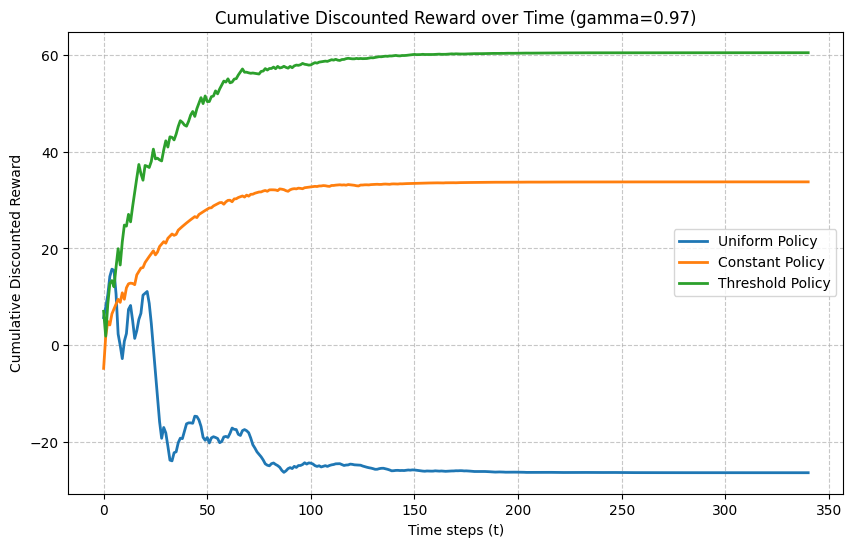

In [39]:
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum

# Uniform Policy
States1,  Reward1 = SimulateTrajectory(T,PiUniform, s1)
# Constant Policy 
States2, Reward2 = SimulateTrajectory(T, PiConstant, s1)
# Threshold Policy 
States3, Reward3 = SimulateTrajectory(T, PiThreshold, s1)

discount_factors = np.power(gamma, np.arange(T)) 

# Discounted Rewards
DiscountRewards1 = Reward1 * discount_factors
DiscountRewards2 = Reward2 * discount_factors
DiscountRewards3 = Reward3 * discount_factors

# Discounted Cumulative Sum
CumDiscReward1 = np.cumsum(DiscountRewards1)
CumDiscReward2 = np.cumsum(DiscountRewards2)
CumDiscReward3 = np.cumsum(DiscountRewards3)

# Plot 
plt.figure(figsize=(10, 6))

plt.plot(CumDiscReward1, label="Uniform Policy", linewidth=2)
plt.plot(CumDiscReward2, label="Constant Policy", linewidth=2)
plt.plot(CumDiscReward3, label="Threshold Policy", linewidth=2)


plt.title(f"Cumulative Discounted Reward over Time (gamma={gamma})")
plt.xlabel("Time steps (t)")
plt.ylabel("Cumulative Discounted Reward")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()



### Evolution of the stock

Text(0.5, 1.0, 'Evolution of the stock under a threshold policy')

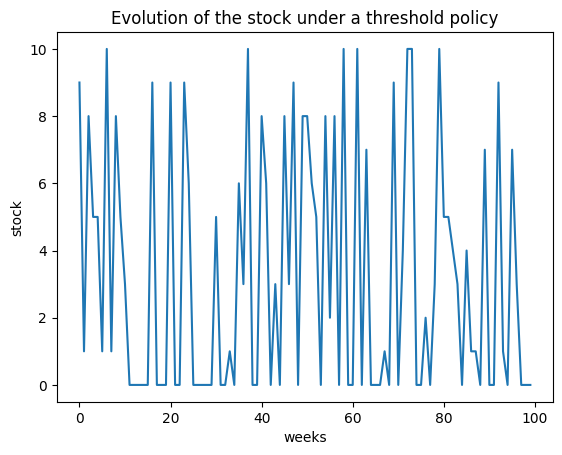

In [11]:
plt.figure()
plt.plot(States3[range(100)])
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a threshold policy')

# Dynamic Programming

So far, when doing simulations, we just interacted with the environements with calls to the "step" functions (which boils down to simulating the demand each week). However, we assume that all the parameters (including the demand distribution itself, paramterized by $q$) are known, we can evaluate policies, and compute the optimal policy using the knowledge of the MDP parameters (encoded in env.P and env.r).

In [12]:
env = StoreManagement(0,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1)

# MDP parameters
P = env.P # P[s,a,s'] = p(s' | s,a) 
r = env.r # r[s,a] = average reward received in state s when playing action a

## Evaluation of deterministic policies

**Evalute a policy of your choice using Monte-Carlo simulation, i.e. compute the value of this policy in all states.** 

In a Monte-Carlo simulation to estimate the value of $V^\pi(s)$, we collect `MC` values for the sum of discounted rewards over long enough trajectories starting at $s$, then compute the mean of these `MC` values.
We need to compute trajectories from *all* states.

Observe that we do *not* need the knowledge of $P$ and $r$ for this method, simulating trajectories is enough.

In [17]:
## Computes the values in each state by Monte-Carlo simulation (needs many simulations to be precise)

Policy = PiThreshold

MC = 100 # number of Monte-Carlo simulations
Values_MCMC = np.zeros(M+1)


for s in range(M+1):
    mc_values = []
    for i in range(MC):
        States, Rewards = SimulateTrajectory(T,Policy,s)
        discounts = gamma ** np.arange(len(Rewards))
        discounted_sum = np.sum(Rewards * discounts)
        mc_values.append(discounted_sum)
    Values_MCMC[s] = np.mean(mc_values)



print("the estimated value in each states for the threshold policy are:")

print(Values_MCMC)
    

the estimated value in each states for the threshold policy are:
[49.07133279 49.20616916 48.99849034 49.31071652 49.14788167 50.2587571
 49.68725476 49.37077809 50.71466712 48.49847805 51.73050009 50.05095839
 49.00334598 52.69314196 54.49115652 52.15957845]


**Implement a function that evaluates a deterministic policy Pi using the matrix inversion technique. Compare the output with the previous method for the same policy.**

Unlike the previous evaluation method, this one requires the knowledge of $P$ and $r$. 

Tout part de l'équation de Bellman pour une politique fixée π. En écriture matricielle, elle ressemble à ça :

$$ V^\pi = R^\pi + \gamma P^\pi V^\pi $$

Où :
V 
π
  est le vecteur des valeurs que l'on cherche.
R 
π
  est le vecteur des récompenses immédiates.
P 
π
  est la matrice de transition induite par la politique.
On veut isoler V 
π
 . Avec un peu d'algèbre linéaire :

$$ V^\pi - \gamma P^\pi V^\pi = R^\pi $$ $$ (I - \gamma P^\pi) V^\pi = R^\pi $$

Ce qui nous donne la solution finale : $$ V^\pi = (I - \gamma P^\pi)^{-1} R^\pi $$

In [31]:
def EvaluatePolicy(Pi):
    # input: function (could also be vector as we can only use this method for deterministic policies)
    # ** TO BE COMPLETED **
    # should return a vector of values
    P_pi = np.zeros((M+1, M+1))
    R_pi = np.zeros(M+1)
    is_function = callable(Pi)

    for s in range(M+1):
        if is_function:
            action = Pi(s)
        else:
            action = Pi[s]
        action = int(action)
            
        P_pi[s, :] = P[s, action, :]
        R_pi[s] = r[s, action]

    I = np.eye(M+1)
    A = I - gamma * P_pi
    b = R_pi

    Values = np.linalg.solve(A, b)

    return Values 

Policy = PiThreshold
Values_matrix = EvaluatePolicy(Policy)

print(Values_matrix)
    

[48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]


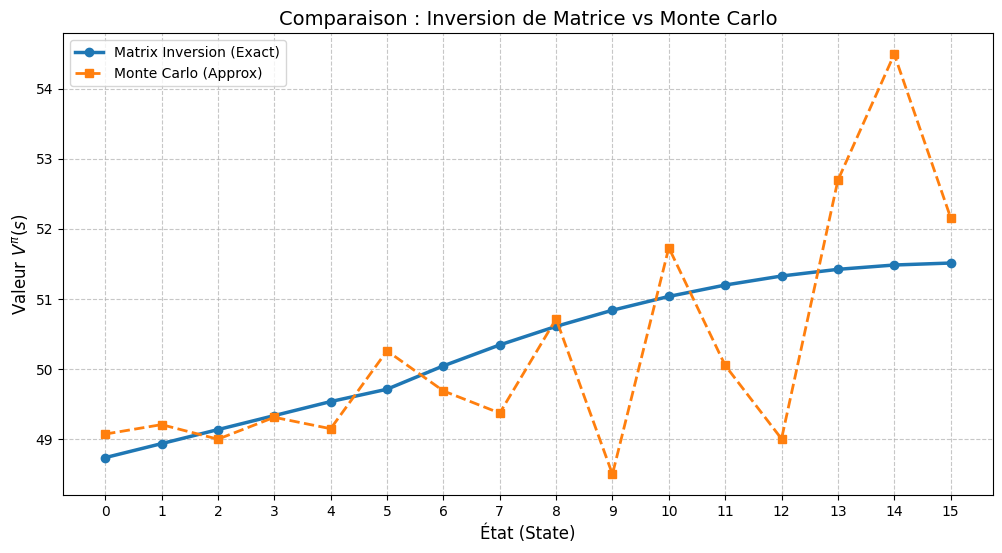

In [25]:
states = np.arange(len(Values_matrix))

plt.figure(figsize=(12, 6))


plt.plot(states, Values_matrix, 'o-', label='Matrix Inversion (Exact)', linewidth=2.5)
plt.plot(states, Values_MCMC, 's--', label='Monte Carlo (Approx)', linewidth=2)

plt.title('Comparaison : Inversion de Matrice vs Monte Carlo', fontsize=14)
plt.xlabel('État (State)', fontsize=12)
plt.ylabel('Valeur $V^\pi(s)$', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(states) 

plt.show()

**Evaluate two different policies and visualize their values for the different states in order to decide which one is better.** 

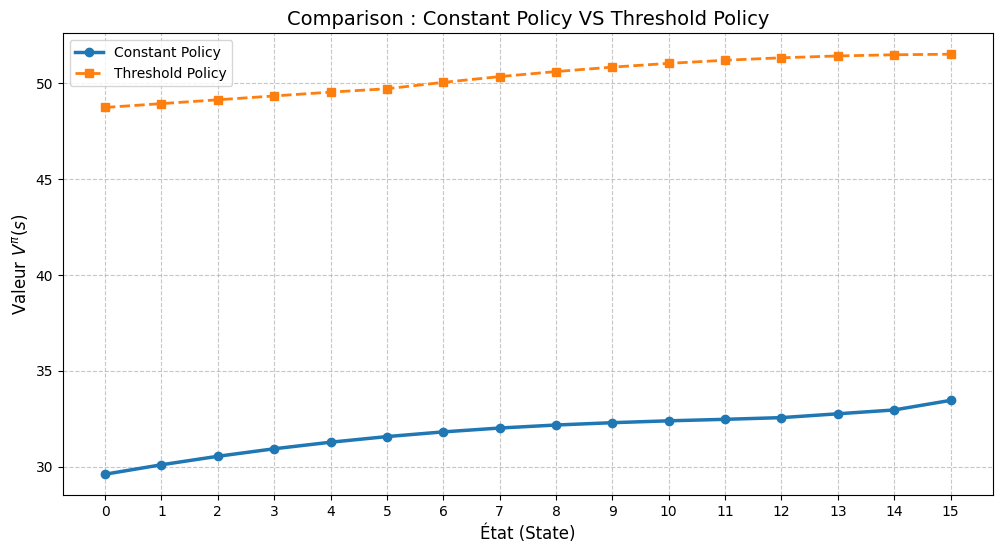

In [26]:
Values_piconstant = EvaluatePolicy(PiConstant)
Values_pithreshold = EvaluatePolicy(PiThreshold)

states = np.arange(len(Values_matrix))

plt.figure(figsize=(12, 6))


plt.plot(states, Values_piconstant, 'o-', label='Constant Policy', linewidth=2.5)
plt.plot(states, Values_pithreshold, 's--', label='Threshold Policy', linewidth=2)

plt.title('Comparison : Constant Policy VS Threshold Policy', fontsize=14)
plt.xlabel('État (State)', fontsize=12)
plt.ylabel('Valeur $V^\pi(s)$', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(states) 

plt.show()


## Computing the Optimal Policy: Policy Iteration 

The function given below performs policy improvement, and may be useful to implement both value iteration and policy iteration. Note that the (deterministic) policy it outputs is encoded as a vector, not a function. 


In [27]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and 
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV


V = np.random.randint(M+1,size=M+1) 
newPi,newV = Improve(V)
print("improved policy from random:",newPi)

improved policy from random: [1 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0]


**Implement Value Iteration and Policy Iteration.**

First, check that the two algorithms output the same optimal policy. Then, you may compare the number of iteration needed by both algorithms as well as the executation time. 

In [33]:
def ValueIteration(epsilon=1e-3): # epsilon = guaranteed precision
    #Initialisation V0 arbitrairement
    V = np.zeros(M + 1)
    #Itération jusqu'à Vk+1-Vk<epsilon
    itr = 0
    while True:
        itr+=1
        Pi, newV = Improve(V)
        diff = np.max(np.abs(newV - V))
        V = newV
        if diff < epsilon:
            break    
    #Retourner la politique gloutonne par rapport à Vfinal 
    return Pi, V, itr

# Lancer l'algorithme
Optimal_Policy, Optimal_Value, itr = ValueIteration(epsilon=0.001)

print("Politique Optimale :", Optimal_Policy)
print("Valeurs Optimales :", Optimal_Value)
print("Nombre d'itérations:", itr)

Politique Optimale : [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0]
Valeurs Optimales : [48.83663374 49.03663374 49.23663374 49.43663374 49.63663374 49.83663374
 50.1439058  50.44232457 50.70652933 50.93663374 51.13275109 51.2949943
 51.4234759  51.51830806 51.57960257 51.60747086]
Nombre d'itérations: 241


In [32]:
def PolicyIteration():
    #Initialisation Pi0
    Pi = np.zeros(M + 1)
    itr = 0 
    #Répéter jusqu'à ce que la politique ne change plus 
    while True:
        itr+=1
        #Evaluation 
        V_Pi = EvaluatePolicy(Pi)
        #Amélioration
        new_Pi, new_V_Pi= Improve(V_Pi)
        new_Pi = new_Pi.astype(int)

        if np.array_equal(new_Pi, Pi):
            break

        #Mise à jour 
        Pi = new_Pi

    return Pi, new_V_Pi, itr

Optimal_Policy, Optimal_Value, itr = PolicyIteration()
print("Politique Optimale :", Optimal_Policy)
print("Valeurs Optimales :", Optimal_Value)
print("Nombre d'itérations:", itr)

Politique Optimale : [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0]
Valeurs Optimales : [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]
Nombre d'itérations: 4


In [34]:

start = time.time()
Pi,V,nIt = ValueIteration()
elapsed = time.time()-start

start = time.time()
Pi2,V2,nIt2 = PolicyIteration()
elapsed = time.time()-start

print("Value iteration yields policy",Pi,"and value ",V," in ",nIt," iterations and t=",elapsed," seconds\n")
print("Optimal policy is",Pi2,"with value ",V2," in ",nIt2," iterations and t=",elapsed," seconds")


Value iteration yields policy [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0] and value  [48.83663374 49.03663374 49.23663374 49.43663374 49.63663374 49.83663374
 50.1439058  50.44232457 50.70652933 50.93663374 51.13275109 51.2949943
 51.4234759  51.51830806 51.57960257 51.60747086]  in  241  iterations and t= 0.005506038665771484  seconds

Optimal policy is [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0] with value  [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]  in  4  iterations and t= 0.005506038665771484  seconds


Here is a visualization of the optimal policy. 

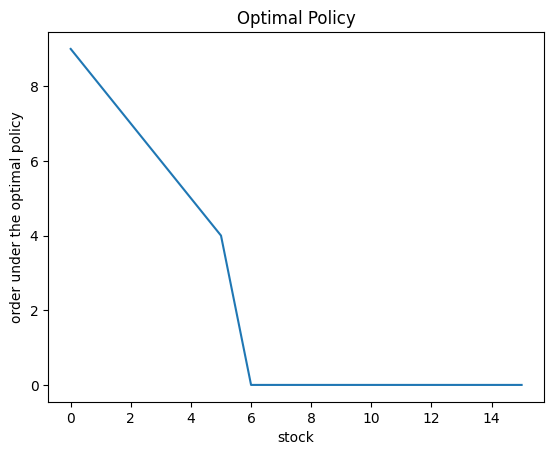

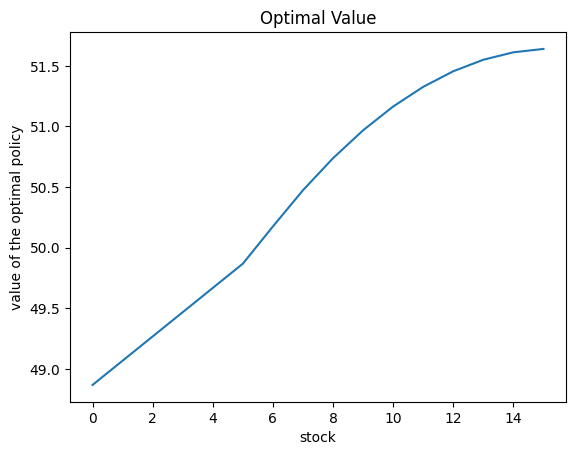

In [35]:
plt.plot(Pi2)
plt.xlabel('stock')
plt.ylabel('order under the optimal policy')
plt.title("Optimal Policy")

plt.figure()
plt.plot(V2)
plt.xlabel('stock')
plt.ylabel('value of the optimal policy')
plt.title("Optimal Value")

Vstar=np.copy(V)

**Plot the number of iterations needed for value iteration as a function of the precision parameter $\varepsilon$**

Try powers of 10: $\varepsilon=1

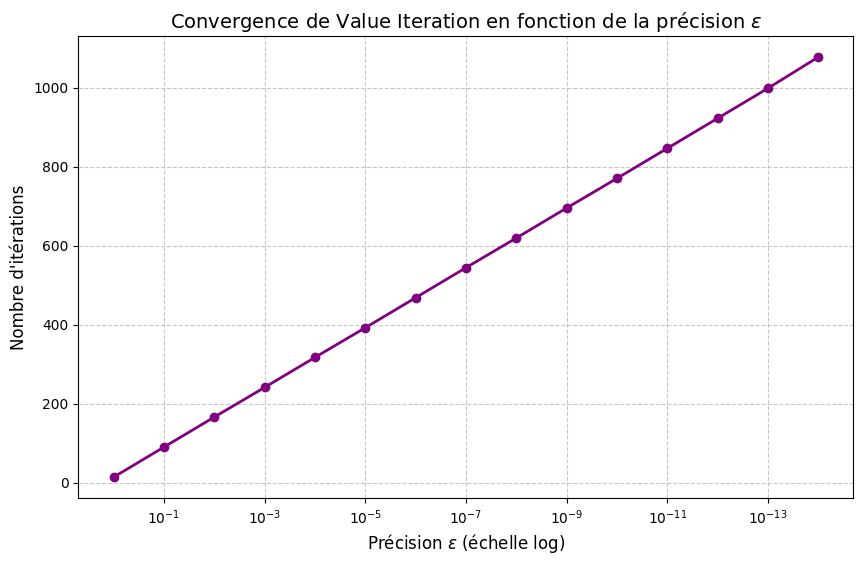

In [38]:
epsilons = [10**(-i) for i in range(15)] 


iterations_needed = []
for eps in epsilons:
    _,_,k = ValueIteration(eps)
    iterations_needed.append(k)


plt.figure(figsize=(10, 6))
plt.plot(epsilons, iterations_needed, 'o-', color='purple', linewidth=2)

# Configuration de l'échelle logarithmique pour epsilon
plt.xscale('log')

# On inverse l'axe X : epsilon décroît (précision augmente) vers la droite
plt.gca().invert_xaxis() 

plt.xlabel('Précision $\epsilon$ (échelle log)', fontsize=12)
plt.ylabel("Nombre d'itérations", fontsize=12)
plt.title('Convergence de Value Iteration en fonction de la précision $\epsilon$', fontsize=14)
plt.grid(True, which="both", linestyle='--', alpha=0.7)

plt.show()